<a href="https://colab.research.google.com/github/DrMiracle/Colab-Projects/blob/main/graphs%20and%20algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import random
import heapq
import networkx as nx
import numpy as np

In [ ]:
def plot_connected_points(point1, point2):
  plt.plot([point1.x,point2.x], [point1.y, point2.y], 'k-')

In [ ]:
class Point:
  def __init__(self, x, y, refueling = False, adjasent_points=[]):
    self.x = x
    self.y = y
    self.refueling = refueling
    self.adjasent_points=adjasent_points

  def __str__(self):
    return "({}, {}) refueling: {}, neighbours: {}".format(self.x, self.y, self.refueling, len(self.adjasent_points))

  def __lt__(self, p):
    return True

In [ ]:
class Random_Graph:
  def __init__(self, n_vertices, prob, ref_prob, adjasent_matrix=[],points=[]):
    self.n_vertices = n_vertices
    self.prob = prob
    self.ref_prob = ref_prob
    self.adjasent_matrix = np.random.choice(a = (0, 1), size = (n_vertices,n_vertices), p = (1-prob, prob))
    self.adjasent_matrix = self.adjasent_matrix*np.abs((np.tri(n_vertices, n_vertices).T-1))
    self.adjasent_matrix = self.adjasent_matrix + self.adjasent_matrix.T
    self.create_random_points()
    self.connect_vertices()

  def create_random_points(self):
    points = []
    ref_vec = np.random.choice(a = (False, True), size = (self.n_vertices,), p = (1-self.ref_prob, self.ref_prob))
    for i in range(self.n_vertices):
      while True:
        point = Point(x=random.randint(1,self.n_vertices), y=random.randint(1,self.n_vertices), refueling = ref_vec[i], adjasent_points=[])
        if(point.x, point.y) in [(point.x, point.y) for point in points]:
          continue
        else:
          points.append(point)
          break
    self.points=points

  def connect_vertices(self):
    for i in range(self.n_vertices):
      point = self.points[i]
      for j in range(self.n_vertices):
        if self.adjasent_matrix[i][j] == 1:
          point.adjasent_points.append(self.points[j])

In [ ]:
graph = Random_Graph(n_vertices=10, prob=0.1, ref_prob=0.1)

In [ ]:
plot_points = []
for point in graph.points:
  for adjasent_point in point.adjasent_points:
    coordinate = ((point.x,adjasent_point.x), (point.y, adjasent_point.y))
    if coordinate not in plot_points:
      plot_points.append(coordinate)

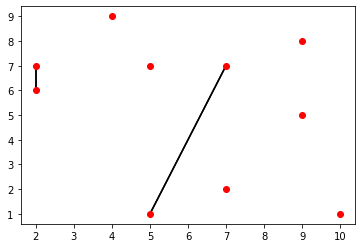

In [ ]:
for point_pair in plot_points:
  plt.plot([point_pair[0][0],point_pair[0][1]], [point_pair[1][0],point_pair[1][1]], 'k-')
for point in graph.points:
  if point.refueling:
    plt.plot(point.x, point.y, "bo")
  else:
    plt.plot(point.x, point.y, "ro")

In [ ]:
def euclidean_distance(p1, p2):
  return np.sqrt((p1.x-p2.x)**2 + (p1.y-p2.y)**2)

def algorithm_a_star(graph, start, goal):
  frontier = []
  heapq.heappush(frontier, (0, start))
  came_from = dict()
  cost_so_far = dict()
  came_from[start] = None
  cost_so_far[start] = 0

  while len(frontier):
    _,current = heapq.heappop(frontier)

    if current == goal:
      return True, cost_so_far[current], came_from

    for next in current.adjasent_points:
      new_cost = cost_so_far[current] + euclidean_distance(current, next)
      if next not in cost_so_far or new_cost < cost_so_far[next]:
        cost_so_far[next] = new_cost
        priority = new_cost + euclidean_distance(goal, next)
        heapq.heappush(frontier, (priority, next))
        came_from[next] = current
  return False, "no path", came_from


In [ ]:
def algorithm_with_rejection(graph, start, goal, L):
  frontier = []
  heapq.heappush(frontier, (0, start, L))
  came_from = dict()
  cost_so_far = dict()
  fuel_in = dict()
  came_from[start] = None
  cost_so_far[start] = 0

  while len(frontier):
    _,current,l = heapq.heappop(frontier)

    if current == goal:
      return True, cost_so_far[current], came_from, fuel_in

    for next in current.adjasent_points:
      new_cost = cost_so_far[current] + euclidean_distance(current, next)
      if l > euclidean_distance(current, next):
        if next not in cost_so_far or new_cost < cost_so_far[next]:
          cost_so_far[next] = new_cost
          fuel_in[next] = l-euclidean_distance(current, next)
          priority = new_cost + euclidean_distance(goal, next)
          if next.refueling:
            heapq.heappush(frontier, (priority, next, L))
          else:
            heapq.heappush(frontier, (priority, next, l-euclidean_distance(current, next)))
          came_from[next] = current
  return False, "no path", came_from, fuel_in

In [ ]:
def combined_algorithm(graph, start, goal, L, func_u):
  frontier = []
  heapq.heappush(frontier, (0, start, L))
  came_from = dict()
  cost_so_far = dict()
  fuel_in = dict()
  came_from[start] = None
  cost_so_far[start] = 0

  while len(frontier):
    _,current,l = heapq.heappop(frontier)

    if current == goal:
      return True, cost_so_far[current], came_from, fuel_in

    for next in current.adjasent_points:
      new_cost = cost_so_far[current] + euclidean_distance(current, next)
      if l > euclidean_distance(current, next):
        if next not in cost_so_far or new_cost < cost_so_far[next]:
          cost_so_far[next] = new_cost
          fuel_in[next] = l-euclidean_distance(current, next)
          priority = (new_cost + euclidean_distance(goal, next))/func_u(l-euclidean_distance(current, next))
          if next.refueling:
            heapq.heappush(frontier, (priority, next, L))
          else:
            heapq.heappush(frontier, (priority, next, l-euclidean_distance(current, next)))
          came_from[next] = current
  return False, "no path", came_from, fuel_in

In [ ]:
find, cost, path = algorithm_a_star(graph, graph.points[0], graph.points[1])
if find:
  print(cost)

  c = graph.points[1]
  while c is not None:
    if path[c] is not None:
      print("Point: {}, Distance: {}".format(c, euclidean_distance(c, path[c])))
    else:
      print("Point: {}".format(c))
    c = path[c]
else:
  print(cost)


no path


In [ ]:
from timeit import default_timer as timer

def func_u(l):
  return np.maximum(0.0001, float(l))

graph = Random_Graph(n_vertices=1000, prob=0.3, ref_prob=0.3)

start = graph.points[0]
end = graph.points[1]
print(start, end)
start.refueling = True
end.refueling = True

st = timer()
find, cost, path, fuel = combined_algorithm(graph, start, end, 100, func_u)
et = timer()
print(et-st)

if find:
  print("Distance: {}".format(cost))
  c = end
  while c is not None:
    if path[c] is not None:
      print("Point: {}, Distance: {}, Fuel: {}".format(c, euclidean_distance(c, path[c]), fuel[c]))
    else:
      print("Point: {}".format(c))
    c = path[c]
else:
  print(cost)

st = timer()
find, cost, path, fuel = algorithm_with_rejection(graph, start, end, 100)
et = timer()
print(et-st)

if find:
  print("Distance: {}".format(cost))
  c = end
  while c is not None:
    if path[c] is not None:
      print("Point: {}, Distance: {}, Fuel: {}".format(c, euclidean_distance(c, path[c]), fuel[c]))
    else:
      print("Point: {}".format(c))
    c = path[c]
else:
  print(cost)


(503, 703) refueling: True, neighbours: 290 (699, 350) refueling: False, neighbours: 296
2.4129615199999535
Distance: 614.1873294099836
Point: (699, 350) refueling: True, neighbours: 296, Distance: 43.829214001622255, Fuel: 0.8083438557121099
Point: (663, 325) refueling: False, neighbours: 303, Distance: 55.362442142665635, Fuel: 44.637557857334365
Point: (679, 378) refueling: True, neighbours: 306, Distance: 49.76946855251722, Fuel: 11.179283067949513
Point: (660, 424) refueling: False, neighbours: 301, Distance: 39.05124837953327, Fuel: 60.94875162046673
Point: (630, 449) refueling: True, neighbours: 310, Distance: 62.433965115151864, Fuel: 37.566034884848136
Point: (577, 482) refueling: True, neighbours: 304, Distance: 61.61168720299745, Fuel: 38.38831279700255
Point: (517, 496) refueling: True, neighbours: 279, Distance: 33.94112549695428, Fuel: 66.05887450304573
Point: (493, 520) refueling: True, neighbours: 264, Distance: 31.575306807693888, Fuel: 68.42469319230611
Point: (499, 5

In [ ]:
def func_u(l):
  return np.maximum(0.00001, l)

def evaluate(n, p, fp, l):
  graph = Random_Graph(n, p, fp)

  start = graph.points[0]
  end = graph.points[1]
  start.refueling = True
  end.refueling = True

  st = timer()
  find_r, cost_r, path_r, fuel_r = algorithm_with_rejection(graph, start, end, l)
  et = timer()
  time_rej = et-st

  min_fuel_r = l
  if find_r:
    c = end
    while c is not start:
      if fuel_r[c] < min_fuel_r:
        min_fuel_r = fuel_r[c]
      c = path_r[c]

  st = timer()
  find_c, cost_c, path_c, fuel_c = combined_algorithm(graph, start, end, l, func_u)
  et = timer()
  time_com = et-st

  min_fuel_c = l
  if find_c:
    c = end
    while c is not start:
      if fuel_c[c] < min_fuel_c:
        min_fuel_c = fuel_c[c]
      c = path_c[c]

  rej_a = (time_rej, find_r, cost_r, min_fuel_r)
  com_a = (time_com, find_c, cost_c, min_fuel_c)
  return rej_a, com_a

In [ ]:
for fp in [0.3, 0.5, 0.7]:
  for p in [0.3, 0.5, 0.7]:
    avg_time_r = 0
    avg_dist_r = 0
    avg_min_f_r = 0

    avg_time_c = 0
    avg_dist_c = 0
    avg_min_f_c = 0

    for i in range(1000):
      rej_a, com_a = evaluate(100, p, fp, 50)
      time, find, dist, min_f = rej_a

      avg_time_r+=time
      if find:
        avg_dist_r+=dist
        avg_min_f_r+=min_f

      time, find, dist, min_f = com_a

      avg_time_c+=time
      if find:
        avg_dist_c+=dist
        avg_min_f_c+=min_f

    avg_time_r/=1000
    avg_dist_r/=1000
    avg_min_f_r/=1000

    avg_time_c/=1000
    avg_dist_c/=1000
    avg_min_f_c/=1000

    print("P: {}, F_P: {}".format(p, fp))
    print("Rejection - Time: {}, Dist: {}, Min fuel: {}".format(avg_time_r, avg_dist_r, avg_min_f_r))
    print("Combine - Time: {}, Dist: {}, Min fuel: {}".format(avg_time_c, avg_dist_c, avg_min_f_c))

P: 0.3, F_P: 0.3
Rejection - Time: 0.001587122505019579, Dist: 61.85507486651697, Min fuel: 12.200077667938478
Combine - Time: 0.006747396454979025, Dist: 65.38515574650569, Min fuel: 13.886464163963963
P: 0.5, F_P: 0.3
Rejection - Time: 0.001678069437017257, Dist: 55.67738607435826, Min fuel: 13.282662273970137
Combine - Time: 0.010729750470021827, Dist: 57.55208847268204, Min fuel: 14.918622774142538
P: 0.7, F_P: 0.3
Rejection - Time: 0.0018389198310178473, Dist: 52.98975679817978, Min fuel: 13.676558795230525
Combine - Time: 0.014414428606998627, Dist: 54.629332937830696, Min fuel: 15.255384710412663
P: 0.3, F_P: 0.5
Rejection - Time: 0.0012154647559709702, Dist: 59.86148987943144, Min fuel: 12.901952192860014
Combine - Time: 0.00732612001999405, Dist: 63.02081830031425, Min fuel: 15.520444897474823
P: 0.5, F_P: 0.5
Rejection - Time: 0.0013036733030239703, Dist: 55.529022550827904, Min fuel: 13.90969576415104
Combine - Time: 0.011904426683984639, Dist: 57.406338951810554, Min fuel: 